In [1]:
import os
import sys
import pickle
import string
import string
import glob
import cv2

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.cluster import AgglomerativeClustering
from matplotlib.animation import FuncAnimation, MovieWriter
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from itertools import product
from matplotlib import ticker

sys.path.append('..')
import massPy as mp
from utils import *
from plot_utils import *
from AnalyseDefects import AnalyseDefects
plt.style.use('sg_article')
plt.rcParams.update({"text.usetex": True,})


In [2]:

def extract_clp_results_single_v2(clustering_dict, act_dir_list, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    Nframes = clustering_dict['Nframes']
  
    # create arrays to store the clustering data
    cluster_arr = np.nan * np.zeros([Nframes, clustering_dict['Nwindows'], 3, clustering_dict['Nact'],])
    nn_arr = np.nan * np.zeros([Nframes, 2, clustering_dict['Nact']])

    for i, act_dir in enumerate(act_dir_list):
        print(i, act_dir)
        try:
            cl_res = np.load(os.path.join(act_dir, 'cl_arr.npy'))
            ff_idx = min(Nframes, cl_res.shape[0])
            cluster_arr[-ff_idx:, :cl_res.shape[1], :, i] = cl_res[-ff_idx:]
        except:
            print(f"Error loading clustering data from {act_dir}")
        try:
            nn_res = np.load(os.path.join(act_dir, 'nn_arr.npy'))
            ff_idx = min(Nframes, nn_res.shape[0])
            nn_arr[-ff_idx:, :, i] = nn_res[-ff_idx:]
        except:
            print(f"Error loading nn data from {act_dir}")
            continue
            
    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)
        np.save(os.path.join(save_path, f'clp_arr.npy'), cluster_arr)
        np.save(os.path.join(save_path, f'nn_arr.npy'), nn_arr)
    return cluster_arr

def extract_clp_results_single(clustering_dict, act_dir_list, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    Nframes = clustering_dict['Nframes']
  
    # create arrays to store the clustering data
    cluster_arr = np.nan * np.zeros([Nframes, clustering_dict['Nwindows'], 3, clustering_dict['Nact'],])
    nn_arr = np.nan * np.zeros([Nframes, 2, clustering_dict['Nact']])

    for i, act_dir in enumerate(act_dir_list):
        print(i, act_dir)
        cl_res = np.load(os.path.join(act_dir, 'cl_arr.npy'))
        nn_res = np.load(os.path.join(act_dir, 'nn_arr.npy'))
        ff_idx = min(Nframes, cl_res.shape[0])
        cluster_arr[-ff_idx:, :cl_res.shape[1], :, i] = cl_res[-ff_idx:]
        nn_arr[-ff_idx:, :, i] = nn_res[-ff_idx:]

    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'clp_arr.npy'), cluster_arr)
        np.save(os.path.join(save_path, f'nn_arr.npy'), nn_arr)
    return cluster_arr

def extract_op_results(Nframes, act_dir_list, LX, calc_sem = False, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    order_param_arr = np.nan * np.zeros([Nframes, 4, len(act_dir_list)])
    normalizer = np.sqrt(LX ** 2) if calc_sem else 1

    for i, act_dir in enumerate(act_dir_list):
        print(i, act_dir)

        op_res = np.load(os.path.join(act_dir, 'order_param_arr.npy'))
        ff_idx = min(Nframes, op_res.shape[0])

        order_param_arr[-ff_idx:, :, i] = op_res[-ff_idx:]
        order_param_arr[-ff_idx:, 1, i] /= normalizer
        order_param_arr[-ff_idx:, 3, i] /= normalizer

    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'order_param_arr.npy'), order_param_arr)
    return order_param_arr

def extract_dc_results(Nframes, act_dir_list, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    for i, act_dir in enumerate(act_dir_list):
        print(i, act_dir)

        if i == 0:
            rvals = np.load(os.path.join(act_dir, 'rdf_rad_arr.npy'))
            rdf_arr = np.nan * np.zeros([Nframes, len(rvals), len(act_dir_list)])

        rdf = np.load(os.path.join(act_dir, 'rdf_arr.npy'))
        ff_idx = min(Nframes, rdf.shape[0])

        rdf_arr[-ff_idx:, :, i] = rdf[-ff_idx:]

    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'rvals.npy'), rvals)
        np.save(os.path.join(save_path, f'rdf_arr.npy'), rdf_arr)
    return rdf_arr, rvals

def get_defect_arr_from_frame(defect_dict, return_charge = False):
    """
    Convert dictionary of defects to array of defect positions
    Parameters:
    -----------
    defect_dict : dict
        Dictionary of defects positions and charges
    return_charge : bool
        If True, return defect charges as well

    Returns:
    --------
    defect_positions : np.ndarray
        Array of defect positions
    defect_charges : np.ndarray
    """

    Ndefects = len(defect_dict)
    if Ndefects == 0:
        return None
    
    defect_positions = np.empty([Ndefects, 3 if return_charge else 2])

    for i, defect in enumerate(defect_dict):
        if return_charge:
            defect_positions[i,:] = *defect['pos'], defect['charge']
        else:
            defect_positions[i,:] = *defect['pos'],
    return defect_positions

def arg_func(arr, r_max_list, cutoff):
    if np.any(arr == cutoff):
        return r_max_list[np.argwhere(arr == cutoff)[0][0]]
    else:
        return -1
    
def arg_func_idx(arr, cutoff):
    if np.any(arr == cutoff):
        return np.argwhere(arr == cutoff)[0][0]
    else:
        return -1

def arg_func2(arr, cutoff):
    if np.any(arr == cutoff):
        return arr[np.argwhere(arr == cutoff)[0][0]]
    else:
        return -1
    
def get_defect_density(defect_list, area, return_charges=False, save_path = None,):
        """
        Get defect density for each frame in archive
        parameters:
            defect_list: list of lists of dictionaries holding defect charge and position for each frame 
            area: Area of system
            return_charges: if True, return list of densities of positive and negative defects
        returns:
            dens_defects: array of defect densities (Nframes, 3) if return_charges is True else (Nframes, 2)
        """

        if return_charges:
            # Initialize list of defect densities
            dens_pos_defects = []
            dens_neg_defects = []
            for defects in defect_list:
                # Get no. of defects
                nposdef = len([d for d in defects if d['charge'] == 0.5])
                nnegdef = len([d for d in defects if d['charge'] == -0.5])

                dens_pos_defects.append(nposdef / area)
                dens_neg_defects.append(nnegdef / area)

            if save_path is not None:
                np.savetxt(save_path + '_pos', dens_pos_defects)
                np.savetxt(save_path + '_neg', dens_neg_defects)
            return dens_pos_defects, dens_neg_defects
        else:
            dens_defects = []
            for defects in defect_list:
                # Get no. of defects
                ndef = len(defects)
                dens_defects.append(ndef / area)
            if save_path is not None:
                np.savetxt(save_path, dens_defects)
            return dens_defects

def find_conv_time(def_arr, act_list, out_path, fig_path, ninfo, LX, mode='fwd', plot_density = False, \
                   stationarity_dict = dict(interval_len = 20, Njump = 20, Nconverged = -100, max_sigma_dist = 1)):

    Nframes, Nact = def_arr.shape
    conv_list = np.zeros(Nact)

    ncols=3
    nrows = np.ceil(Nact / ncols).astype(int)
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=(12, 3*nrows))
    ax = ax.flatten()


    for i, act in enumerate(act_list):

            normalizer = LX ** 2 if plot_density else 1
            vals = def_arr[:, i] / normalizer

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                x = est_stationarity(vals, **stationarity_dict)[0]

            conv_list[i] = x
            ax[i].plot(np.arange(0, Nframes * ninfo, ninfo), vals, '.',
                        alpha = .5, markersize=9, label = rf'$dQ$ = {act}')
        
            if x > 0:
                ax[i].axvline(x * ninfo, color='black', linestyle='--', alpha=0.5)
            ylims = ax[i].get_ylim()

            ax[i].set_ylim([ylims[0], 1.1 * ylims[1]])
            ax[i].legend()  
            ax[i].grid(True)


    fig.supxlabel('Time')
    fig.supylabel('Number of defects')


    np.save(os.path.join(out_path, 'conv_list.npy'), conv_list)
    fig.savefig(os.path.join(fig_path, f'num_defects_{mode}{LX}.png'))

    # close figure
    plt.close(fig)
    return

def calc_lmax_lperc(clp_arr, rmax_list, act_list, conv_list, save_path, uncertainty_multiplier = 1, nmin_frames = 20):
    

    lmax_av = np.nan * np.zeros((len(act_list), 2))
    lperc_av = np.nan * np.zeros((len(act_list), 2))

    arg_func1d = lambda arr: arg_func(arr, rmax_list, cutoff = 1)
    lmax_arr = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr[:, :, -1, :,])
    lperc_arr = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr[:, :, 0, :,])

    for i, _ in enumerate(act_list):
        ff_idx = int(conv_list[i])

        mask = (lmax_arr[ff_idx:, i,] > 0)
        nsamples = mask.sum()
        if nsamples > nmin_frames:
            arr_res = lmax_arr[ff_idx:, i,][mask]
            lmax_av[i,0] = np.nanmean(arr_res)
            lmax_av[i,1] = np.nanstd(arr_res, ddof = 1,) / np.sqrt(nsamples / uncertainty_multiplier)


        mask_perc = (lperc_arr[ff_idx:, i,] > 0)
        nsamples_perc = mask_perc.sum()
        if nsamples_perc  > nmin_frames:
            arr_res_perc = lperc_arr[ff_idx:, i,][mask_perc]
            lperc_av[i,0] = np.nanmean(arr_res_perc)
            lperc_av[i,1] = np.nanstd(arr_res_perc, ddof = 1,) / np.sqrt(nsamples_perc / uncertainty_multiplier)

    np.save(os.path.join(save_path, 'lmax_arr.npy'), lmax_arr)
    np.save(os.path.join(save_path, 'lperc_arr.npy'), lperc_arr)
    np.save(os.path.join(save_path, 'lmax_av.npy'), lmax_av)
    np.save(os.path.join(save_path, 'lperc_av.npy'), lperc_av)
    return

def calc_nn_avg(nn_arr, def_arr, act_list, conv_list, LX, \
                uncertainty_multiplier = 1, weighted=False, \
                normalize = True, nmin_samples = 20, 
                save_path = None):
    
    nn_av = np.nan * np.zeros((len(act_list), 2))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for j in range(len(act_list)):
            ff_idx = int(conv_list[j])
            normalizer = LX / np.sqrt(def_arr[ff_idx:,j]) if normalize else 1
            
            if (nn_arr[:,0,j] > 0).sum() >=  nmin_samples:
                if weighted:
                    nn_av[j] = calc_weighted_mean_vec(nn_arr[ff_idx:,0,j] / normalizer, 
                                                                nn_arr[ff_idx:,1,j] / normalizer, replace_null_uncertainties=True)[:2]
                    nn_av[j,1] *= np.sqrt(uncertainty_multiplier)
                else:
                    nn_av[j,0] = np.nanmean(nn_arr[ff_idx:,0,j] / normalizer)
                    nn_av[j,1] = np.nanstd(nn_arr[ff_idx:,0,j] / normalizer, ddof = 1,) \
                        / np.sqrt(nn_arr[ff_idx:,0,j].size / uncertainty_multiplier)           
    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, 'nn_av.npy'), nn_av)
    return nn_av

def calc_dc_avg(rdf_arr, act_list, conv_list, \
                uncertainty_multiplier = 1, njump=5,
                save_path = None):
    

    
    rdf_arr_av = np.nan * np.zeros((len(act_list), 2, rdf_arr.shape[1]))
  
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for j in range(len(act_list)):
            ff_idx = int(conv_list[j] / njump)
            rdf_arr_res = rdf_arr[ff_idx:,:,j]
            #nan_mask = np.isnan(rdf_arr_res)
            #rdf_arr_res = rdf_arr_res[~nan_mask]

            rdf_arr_av[j,0,:] = np.nanmean(rdf_arr_res, axis=0)
            rdf_arr_av[j,1,:] = np.nanstd(rdf_arr_res, axis=0, ddof = 1,) \
                / np.sqrt(rdf_arr_res.size / uncertainty_multiplier)        
    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, 'rdf_arr_av.npy'), rdf_arr_av)
    return rdf_arr_av

def calc_order_param_avg(order_param_arr, act_list, conv_list, \
                uncertainty_multiplier = 1, weighted=False, \
                save_path = None):
    
    order_param_av = np.nan * np.zeros((len(act_list), 4))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for j in range(len(act_list)):
            ff_idx = int(conv_list[j])
   
            if weighted:
                order_param_av[j, :2] = calc_weighted_mean_vec(order_param_arr[ff_idx:,0,j], 
                                                            order_param_arr[ff_idx:,1,j] * np.sqrt(uncertainty_multiplier))[:2]
                order_param_av[j, 2:] = calc_weighted_mean_vec(order_param_arr[ff_idx:,2,j], 
                                                            order_param_arr[ff_idx:,3,j] * np.sqrt(uncertainty_multiplier))[:2]
                order_param_av[j,1] *= np.sqrt(uncertainty_multiplier)
                order_param_av[j,3] *= np.sqrt(uncertainty_multiplier)
            else:
                order_param_av[j,0] = np.nanmean(order_param_arr[ff_idx:,0,j])
                order_param_av[j,1] = np.nanstd(order_param_arr[ff_idx:,0,j], ddof = 1,) \
                    / np.sqrt(order_param_arr[ff_idx:,0,j].size / uncertainty_multiplier)           
                order_param_av[j,2] = np.nanmean(order_param_arr[ff_idx:,2,j])
                order_param_av[j,3] = np.nanstd(order_param_arr[ff_idx:,2,j], ddof = 1,) \
                    / np.sqrt(order_param_arr[ff_idx:,2,j].size / uncertainty_multiplier)           
    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, 'order_param_av.npy'), order_param_av)
    return order_param_av
        
def plot_order_param(order_param_arr, act_list, Nframes, ninfo, \
                    act_idx_exclude_list = [], lambda_val=None, save_path=None, \
                    ylim = None, mode = 'wet', direction = 'fwd'):
    
    fig, ax = plt.subplots()

    direction = 'forward' if direction == 'fwd' else 'backward'

    for j in range(len(act_list)):
        if j in act_idx_exclude_list: continue

        xvals = np.arange(0, Nframes * ninfo, ninfo)
        ax.plot(xvals, order_param_arr[:,0,j], '.-', label  = f'{act_list[j]}', alpha = .5)
    ax.set_xlabel('Time step')
    ax.set_ylabel('Order parameter (S)')

    ax.legend(ncols=7, loc='upper right',fontsize=12)   
    ax.set_title(rf' $\lambda = ${lambda_val} ({direction})' if mode == 'wet' else rf'Dry ({direction})')
    if ylim is not None:
        ax.set_ylim(ylim)

    fig.tight_layout()  

    if save_path is not None:
        fig.savefig(save_path)
    return fig, ax

def plot_order_param_double(order_param_arr, act_list, idx_lower, Nframes, ninfo, \
                    act_idx_exclude_list = [], lambda_val=None, save_path=None, \
                    ylim_list = None, mode = 'wet', direction = 'fwd'):
    
    fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
    for j in range(len(act_list)):
        if j in act_idx_exclude_list: continue
        ff_idx = 0
        ax[0 if j<idx_lower else 1].plot(order_param_arr[:,0,j], label  = f'{act_list[j]}')
    fig.supxlabel('Time step')
    fig.supylabel('Order parameter (S)')
    fig.suptitle(rf' $\lambda = ${lambda_val} ({direction})' if mode == 'wet' else rf'Dry ({direction})')
    fig.tight_layout()

    for i, axx in enumerate(ax):
        axx.set_ylim([-.05, .25]) if ylim_list is None else axx.set_ylim(ylim_list[i])
        axx.legend(ncol=4, loc='upper right', fontsize=12)

    if save_path is not None:
        fig.savefig(save_path)
    return fig, ax


In [3]:
LX = 256
mode = 'wetmerge' 
save_figs = True
letter_subfigs = True
calc_order_param_sem = False

extract = False
extract_op, extract_dc =False,False
extract_def, find_conv =False, False
analyze=False

nmin_frames = 10 #if #mode == 'wet' else 5
uncertainty_multiplier = 20
njump_between_frames = 5

rmax_list = np.arange(1, int(LX / np.sqrt(2))) 
Nframes = 1000 #if mode=='wet' #else 50
Nwindows = len(rmax_list)
ninfo = 1000

block_size = 20 #if mode=='wet' else 5
Nconverged = 5*block_size

weighted = True

if mode == 'wet':
    folder_name = 'diff_lambda_periodic'
    lambda_list = [0,]# 1] # [0.1, 0.5, 0.8]#1] #1]
    subdir_name = 'wet'
elif mode == 'dry':
    folder_name = 'dry_periodic_long'
    lambda_list = [1,]
    subdir_name = 'dry'
elif mode == 'dryvl':
    folder_name = 'dry_periodic_vl'
    lambda_list = [1,]
    subdir_name = 'dry'
elif mode == 'wetvl':
    folder_name = 'diff_lambda_periodic_vl'
    lambda_list = [0,1]
    subdir_name = 'wet'
elif mode == 'wetmerge':
    folder_name = 'diff_lambda_merge'
    lambda_list = [0,1,]#1]
    subdir_name = 'wet'
elif mode == 'ac':
    folder_name = 'ac_periodic'
    lambda_list = [0,1]
    subdir_name = 'wet'

base_path = f'Z:\\defect_unbinding\\{folder_name}\\{subdir_name}\\na{LX}'
out_path_all = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\{folder_name}\\{mode}\\na{LX}'
figpath_article=f'C:\\Users\\Simon Andersen\\Documents\\Uni\\PhD\\Research\\Defect Unbinding\\Figs\\{folder_name}\\{mode}\\na{LX}'

os.makedirs(out_path_all, exist_ok=True)
os.makedirs(figpath_article, exist_ok=True)

for lambda_val in lambda_list:

    if mode in ['dry', 'dryvl']:
        base_path_fwd = os.path.join(base_path, 'fwd')
        base_path_bck = os.path.join(base_path, 'bck')
    else:
        base_path_fwd = os.path.join(base_path, f'{lambda_val}', 'fwd')
        base_path_bck = os.path.join(base_path, f'{lambda_val}', 'bck')

    extract_fwd = True if os.path.exists(base_path_fwd) else False
    extract_bck = True if os.path.exists(base_path_bck) else False

    out_path_main = os.path.join(out_path_all, f'{lambda_val}')
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')
    fig_path = os.path.join(out_path_main, 'figs')

    if extract or extract_def or extract_op or extract_dc:
        if not os.path.isdir(fig_path): os.makedirs(fig_path)
        if not os.path.isdir(out_path_main): os.makedirs(out_path_main)
        if not os.path.isdir(out_path_fwd): os.makedirs(out_path_fwd)
        if not os.path.isdir(out_path_bck): os.makedirs(out_path_bck)

        print(f'Analyzing {mode} with lambda = {lambda_val}')
        t1 = time.perf_counter()    

        act_dirs_fwd = [os.path.join(base_path_fwd, x) for x in os.listdir(base_path_fwd)] if extract_fwd else []
        act_dirs_bck = [os.path.join(base_path_bck, x) for x in os.listdir(base_path_bck)] if extract_bck else []
        act_fwd = [float(x.split('-')[-2]) for x in os.listdir(base_path_fwd)] if extract_fwd else []
        act_bck = [float(x.split('-')[-2]) for x in os.listdir(base_path_bck)] if extract_bck else []

        # save activity list
        if extract_fwd:
            np.save(os.path.join(out_path_fwd, 'act_fwd.npy'), act_fwd)
        if extract_bck:
            np.save(os.path.join(out_path_bck, 'act_bck.npy'), act_bck)
    else:
        act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy')) if extract_fwd else []
        act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy')) if extract_bck else []

    act_exclude_fwd = []
    act_exclude_bck = []

    Nact_fwd = len(act_fwd)
    Nact_bck = len(act_bck)
    Nact_list = [Nact_fwd, Nact_bck]

    cluster_dict_fwd = dict(LX = LX, Nframes = Nframes, \
                        Nact = len(act_fwd), \
                        Nwindows = len(rmax_list), \
                        path = out_path_fwd, suffix = '_fwd')
    cluster_dict_bck = dict(LX = LX, Nframes = Nframes, \
                        Nact = len(act_bck), \
                        Nwindows = len(rmax_list), \
                        path = out_path_bck, suffix = '_bck')
    
    if extract_def:
            base_path_defects_fwd = os.path.join(base_path, 'defect_positions', 'fwd') if mode in ['dry', 'dryvl'] else os.path.join(base_path,  'defect_positions',f'{lambda_val}', 'fwd')
            base_path_defects_bck = os.path.join(base_path, 'defect_positions', 'bck') if mode in ['dry', 'dryvl'] else os.path.join(base_path,  'defect_positions',f'{lambda_val}', 'bck')

            act_dirs_def_fwd = [os.path.join(base_path_defects_fwd, x) for x in os.listdir(base_path_defects_fwd) if float(x.split('-')[-2]) in act_fwd] if extract_fwd else []
            act_dirs_def_bck = [os.path.join(base_path_defects_bck, x) for x in os.listdir(base_path_defects_bck) if float(x.split('-')[-2]) in act_bck] if extract_bck else []
            
            print("Defect directories fwd:", act_dirs_def_fwd)
            print("Defect directories bck:", act_dirs_def_bck)  
            def_arr_fwd = np.zeros([Nframes, Nact_fwd])
            def_arr_bck = np.zeros([Nframes, Nact_bck])

            for i, (act_dir_list, arr) in enumerate(zip([act_dirs_def_fwd, act_dirs_def_bck], [def_arr_fwd, def_arr_bck])):
                print("Extracting defects for", 'fwd' if i == 0 else 'bck')
                for j, act_dir in enumerate(act_dir_list):
                    print(j)
                    path = os.path.join(act_dir, 'defect_positions.pkl')
                    with open(path, 'rb') as f:
                        defect_dict = pickle.load(f)
                    def_list_pos = get_defect_density(defect_dict, area = 1)
                    ff_idx = min(Nframes, len(def_list_pos))
                    arr[-ff_idx:, j] = def_list_pos[-ff_idx:]
            # save 
            if extract_fwd:
                np.save(os.path.join(out_path_fwd, 'def_arr.npy'), def_arr_fwd)
            if extract_bck:
                np.save(os.path.join(out_path_bck, 'def_arr.npy'), def_arr_bck)
            print(extract_bck, extract_fwd)
    if extract:
        if extract_fwd:
            clp_arr_fwd = extract_clp_results_single(cluster_dict_fwd, act_dirs_fwd, save_path=out_path_fwd)
        if extract_bck:
            clp_arr_bck = extract_clp_results_single(cluster_dict_bck, act_dirs_bck, save_path=out_path_bck)
    else:
        if extract_fwd:
            def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))
            clp_arr_fwd = np.load(os.path.join(out_path_fwd, 'clp_arr.npy'))
            nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
        if extract_bck:
            def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
            clp_arr_bck = np.load(os.path.join(out_path_bck, 'clp_arr.npy'))
            nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
    if extract_op:
        if extract_fwd:
            order_param_arr_fwd = extract_op_results(Nframes, act_dirs_fwd, LX, calc_sem=calc_order_param_sem, save_path=out_path_fwd)
        if extract_bck:
            order_param_arr_bck = extract_op_results(Nframes, act_dirs_bck, LX, calc_sem=calc_order_param_sem, save_path=out_path_bck)
    else:
        try:
            if extract_fwd:
                order_param_arr_fwd = np.load(os.path.join(out_path_fwd, 'order_param_arr.npy'))
            if extract_bck:
                order_param_arr_bck = np.load(os.path.join(out_path_bck, 'order_param_arr.npy'))
        except:
            pass
    if extract_dc:
        if extract_fwd:
            rdf_arr_fwd, rvals_fwd = extract_dc_results(Nframes, act_dirs_fwd, save_path=out_path_fwd)
        if extract_bck:
            rdf_arr_bck, rvals_bck = extract_dc_results(Nframes, act_dirs_bck, save_path=out_path_bck)
    else:
        try:
            if extract_fwd:
                rdf_arr_fwd = np.load(os.path.join(out_path_fwd, 'rdf_arr.npy'))
                rvals_fwd = np.load(os.path.join(out_path_fwd, 'rvals.npy'))
            if extract_bck:
                rdf_arr_bck = np.load(os.path.join(out_path_bck, 'rdf_arr.npy'))
                rvals_bck = np.load(os.path.join(out_path_bck, 'rvals.npy'))
        except:
            pass
    if not find_conv:
        try:
            if extract_fwd:
                conv_list_fwd = np.load(os.path.join(out_path_fwd, 'conv_list.npy'))
            if extract_bck:
                conv_list_bck = np.load(os.path.join(out_path_bck, 'conv_list.npy'))
        except:
            if extract_bck:
                conv_list_bck = np.zeros(Nact_bck)
            if extract_fwd:
                conv_list_fwd = np.zeros(Nact_fwd)
    else:
        if extract_fwd:
            find_conv_time(def_arr_fwd, act_fwd, out_path_fwd, fig_path, ninfo, LX, mode='fwd', plot_density = False, \
                stationarity_dict = dict(interval_len = block_size, Njump = block_size, Nconverged = Nconverged, max_sigma_dist = 1))
        if extract_bck:
            find_conv_time(def_arr_bck, act_bck, out_path_bck, fig_path, ninfo, LX, mode='bck', plot_density = False, \
                stationarity_dict = dict(interval_len = block_size, Njump = block_size, Nconverged = Nconverged, max_sigma_dist = 1))
    if analyze:
        print(f'Analyzing {mode} lambda=', lambda_val) 
        
        if extract_fwd:
            calc_lmax_lperc(clp_arr_fwd, rmax_list, act_fwd, conv_list_fwd, out_path_fwd, \
                        uncertainty_multiplier = uncertainty_multiplier/5 if Nframes<100 else uncertainty_multiplier, \
                            nmin_frames = nmin_frames)
            calc_nn_avg(nn_arr_fwd, def_arr_fwd, act_fwd, conv_list_fwd, LX, \
                uncertainty_multiplier = uncertainty_multiplier, weighted=weighted, normalize = True, nmin_samples = nmin_frames, 
                save_path = out_path_fwd)
            
            try:
                order_param_fwd_av = calc_order_param_avg(order_param_arr_fwd, act_fwd, conv_list_fwd, \
                    uncertainty_multiplier = uncertainty_multiplier, weighted=True, save_path = out_path_fwd)
            except:
                print(r'No order parameter data found for fwd lambda = ', lambda_val)
            try:
                rdf_arr_fwd_av = calc_dc_avg(rdf_arr_fwd, act_fwd, conv_list_fwd, njump=njump_between_frames, \
                                uncertainty_multiplier = uncertainty_multiplier, save_path = out_path_fwd)
            except:
                print(r'No rdf data found for fwd lambda = ', lambda_val)
        if extract_bck:
            calc_lmax_lperc(clp_arr_bck, rmax_list, act_bck, conv_list_bck, out_path_bck, \
                        uncertainty_multiplier = uncertainty_multiplier/5 if Nframes<100 else uncertainty_multiplier, \
                            nmin_frames = nmin_frames)
            calc_nn_avg(nn_arr_bck, def_arr_bck, act_bck, conv_list_bck, LX, \
                    uncertainty_multiplier = uncertainty_multiplier, weighted=weighted, normalize = True, nmin_samples = nmin_frames, 
                    save_path = out_path_bck)
            try:
                order_param_bck_av = calc_order_param_avg(order_param_arr_bck, act_bck, conv_list_bck, \
                    uncertainty_multiplier = uncertainty_multiplier, weighted=True, save_path = out_path_bck)
            except:
                print(r'No order parameter data found for bck lambda = ', lambda_val)
            try:
                rdf_arr_bck_av = calc_dc_avg(rdf_arr_bck, act_bck, conv_list_bck, njump=njump_between_frames, \
                            uncertainty_multiplier = uncertainty_multiplier, save_path = out_path_bck)	
            except:
                print(r'No rdf data found for bck lambda = ', lambda_val)

In [8]:
for i, lambda_val in enumerate([0, 1]):
    #mode = 'wet'
 
    out_path_all = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\{folder_name}\\{mode}\\na{LX}'
    out_path_main = os.path.join(out_path_all, f'{lambda_val}')
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_include_list = [0.03, 0.045, 0.07] if lambda_val == 0 else [.003, 0.004, 0.01]
    act_idx_fwd_include_list = [3, -6, -2,]# -1]

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    rdf_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'rdf_arr_av.npy'))
    rdf_arr_av_bck = np.load(os.path.join(out_path_bck, 'rdf_arr_av.npy'))
    rvals = np.load(os.path.join(out_path_fwd, 'rvals.npy'))

    print(rdf_arr_av_fwd.shape, act_fwd.shape)

(15, 2, 128) (15,)
(10, 2, 128) (10,)


In [ ]:
#### DIRECTOR CORRELATION PLOT ####
plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,
                     })

fig, ax = plt.subplots(ncols=2,figsize=(12, 4.5))
ax = ax.flatten()
normalize=True
marker_list = ['dotted', 'dashed', 'dashdot']
ninfo = 1000

for i, lambda_val in enumerate([0, 1]):
    #mode = 'wet'
    normalizer = LX if normalize else 1
    out_path_all = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\{folder_name}\\{mode}\\na{LX}'
    out_path_main = os.path.join(out_path_all, f'{lambda_val}')
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_include_list = [0.03, 0.045, 0.07] if lambda_val == 0 else [.003, 0.004, 0.01]
    act_idx_fwd_include_list = [3, -6, -2,]# -1]

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    rdf_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'rdf_arr_av.npy'))
    rdf_arr_av_bck = np.load(os.path.join(out_path_bck, 'rdf_arr_av.npy'))
    rvals = np.load(os.path.join(out_path_fwd, 'rvals.npy'))
    act_bck = act_bck #[act_idx_bck_include_list]
    act_fwd = act_fwd #[act_idx_fwd_include_list]
    rdf_arr_av_fwd = rdf_arr_av_fwd #[act_idx_fwd_include_list]
    rdf_arr_av_bck = rdf_arr_av_bck #[act_idx_bck_include_list]
    for j, act in enumerate(act_include_list):
        try:
            act_idx_fwd = np.argwhere(act_fwd == act)[0][0]
            print(act_idx_bck, act)
            ax[i].plot(rvals/LX, rdf_arr_av_fwd[act_idx_fwd, 0,:],'-', color=f'C{j}',  
                       label = rf'$T^* = ${act:.3f}',
                       zorder = -j)
        except:
            pass
        try:
            act_idx_bck = np.argwhere(act_bck == act)[0][0]
            ax[i].plot(rvals/LX, rdf_arr_av_bck[act_idx_bck, 0,:],ls='dashed', color=f'C{j}',zorder = -j)# label = rf'$T^* = ${act:.3f}' if j==0 else None) # $~~~~~~~~~\hspace{5em}$' if i==0 else None)# label=r'$\overline{l_{perc}}$')
        except:
            pass

    ax[i].legend(fontsize=14, loc='upper right', handlelength=1, ncol=1) #if i==0 else None)
    ax[i].set_ylim([-0.1, 1])
    ax[i].set_xlim([-.01, .5])
    ax[i].hlines(0, 0, .5, color='black', lw=1, zorder=-1)
    ax[i].text(0.05, 0.85, rf'$\lambda = ~${lambda_val}', fontsize=22) # transform=ax[i].transAxes, fontsize=22)
    ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(5e-2))
ax[0].set_ylabel(r'Director correlation ($C_{\textbf{nn}} (r)$)')
fig.supxlabel(r'Radial distance ($r/L$)',x=.525,y=0.05)
#
# fig.suptitle(r'Solid: Forward ~~~~~~~~~~~~~~~~~~ Dashed: Backward', fontsize=18, x=.535,y=.935,)# bbox_to_anchor=(0.5, 1.02))#, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')) 
fig.suptitle(r'Forward: $\textbf{---}$ ~~~~~~~~~~~~~~~~~~ Backward: $--$', fontsize=18, x=.535,y=.935,)
#ax[1].set_yscale('log')
for n, AXX in enumerate(ax):
    AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)

fig.tight_layout()
save_path = os.path.join(out_path_all, 'figs')
if not os.path.isdir(save_path):
    os.makedirs(save_path)
if save_figs:
    fig.savefig(os.path.join(save_path, f'correlation.png'), bbox_inches='tight', dpi=520, pad_inches=.1)
    fig.savefig(os.path.join(figpath_article, f'correlation.png'), bbox_inches='tight', dpi=520, pad_inches=.1) 
    print('Saved figure to', os.path.join(figpath_article, f'correlation.png'))

In [ ]:
### Passive RNN plot ###

plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,
                     })

fig, ax = plt.subplots(ncols=2,figsize=(12, 4.))
ax = ax.flatten()
normalize=True
marker_list = ['dotted', 'dashed', 'dashdot']
ninfo = 1000

for i, lambda_val in enumerate(lambda_list):
   # mode = 'wet'
    normalizer = LX if normalize else 1
    out_path_all = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\{folder_name}\\{mode}\\na{LX}'
    
    out_path_main = os.path.join(out_path_all, f'{lambda_val}')
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))

    nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
    nn_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
    nn_arr_av_bck = np.load(os.path.join(out_path_bck, 'nn_av.npy'))


    ax[i].errorbar(act_fwd, nn_arr_av_fwd[:,0], yerr=nn_arr_av_fwd[:,1], alpha=.5,ms=8,fmt='b>-', label=r'Forward', lw=1, elinewidth=2)# if i==0 else None)#$\overline{l_{max}}$ (Forward)' if i==0 else None)# label=r'$\overline{l_{max}}$')
    ax[i].errorbar(act_bck, nn_arr_av_bck[:,0], yerr=nn_arr_av_bck[:,1], fmt='<-',color='darkorange', alpha=.7, ms=8,lw=1, elinewidth=2, label=r'Backward')#  if i==0 else None) # $~~~~~~~~~\hspace{5em}$' if i==0 else None)# label=r'$\overline{l_{perc}}$')

    ax[i].set_ylim([0, .7])#0.8))
    ax[i].set_xlim([-2.5e-3 if i==0 else -2.5e-4, max(act_fwd[-1], act_bck[-1]) + 2.5e-3 if i==0 \
                    else max(act_fwd[-1], act_bck[-1]) + 2.5e-4])


    ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(0.01 if i==0 else 0.001))
    ax[i].hlines(0.5, -.12,.12, linestyle='--', color='black', alpha=0.5,)

    ax[i].legend(fontsize=14, loc='lower right',) # handlelength=1, ncol=1) #if i==0 else None)
    ax[i].text(0.07, 0.1, rf'$\lambda = ~${lambda_val}', transform=ax[i].transAxes, fontsize=22)
    

ax[0].set_ylabel(r'Av. NN-distance ($r_{nn}/r_{av}$)')
fig.supxlabel(r'Effective Temperature ($T^*$)',x=.525,y=0.095)

for n, AXX in enumerate(ax):
    n0 = 0
    AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)
    AXX.text(0.0 if n==0 else 0.0, 1.05, rf"{{\fontfamily{{ntxtlf}}\selectfont\textit{{({string.ascii_lowercase[n]})}}}}", transform=AXX.transAxes,
            size=20,  weight='normal',fontstyle='italic',fontfamily="Times New Roman", color = 'black' if letter_subfigs else 'white',)

fig.tight_layout()
save_path = os.path.join(out_path_all, 'figs')
if not os.path.isdir(save_path):
    os.makedirs(save_path)

if save_figs:
    fig.savefig(os.path.join(save_path, f'rnn_av_v2{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.1)
    fig.savefig(os.path.join(figpath_article, f'rnn_av_v2{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.1) 
    print("Saved figure to ", os.path.join(save_path, f'rnn_av_v2{"_unlabeled" if not letter_subfigs else ""}.png'))

[0.02  0.03  0.04  0.045] (1000, 2, 9)
[0.004 0.005 0.006 0.007 0.008] (1000, 2, 11)


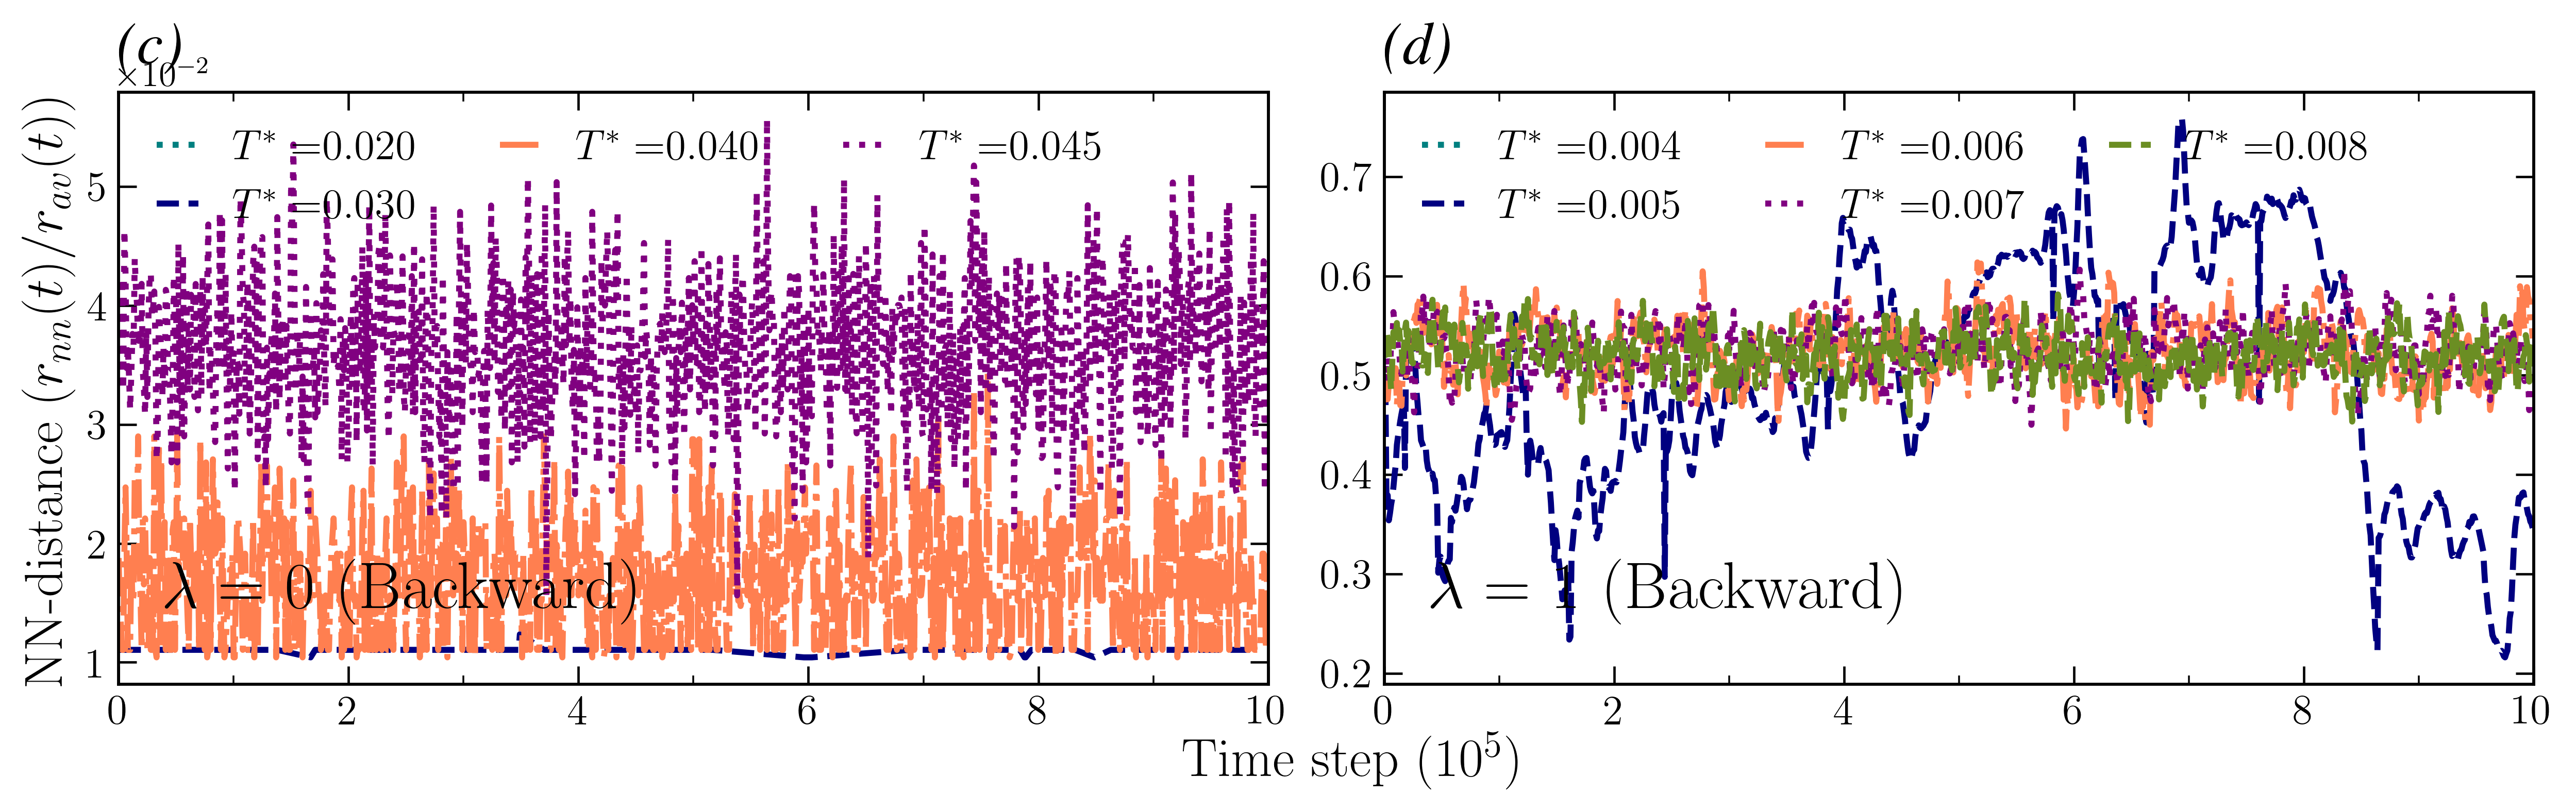

In [7]:
### Passive RNN time series plot ###

plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,
                     })


fig, ax = plt.subplots(ncols=2,figsize=(12, 4.))
ax = ax.flatten()
normalize=True
marker_list = ['dotted', 'dashed', 'dashdot']
ninfo = 1000

for k, lambda_val in enumerate([0, 1]):
    i = k - 2

    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\{folder_name}\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))

    nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
    nn_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
    nn_arr_av_bck = np.load(os.path.join(out_path_bck, 'nn_av.npy'))

    nacts=len(marker_list)
    act_include_list = act_bck[:4] if lambda_val == 0 else act_bck[3:8]

    print(act_include_list, nn_arr_bck.shape)

    ###############################################################################
    xticks = [0, 2e5, 4e5, 6e5, 8e5,10e5]
    xticks_labels = ['0', '2', '4', '6', '8', '10']
    ax[2+i].set_xticks(xticks, xticks_labels)
    ax[2+i].text(0.04, 0.13, rf'$\lambda = ~${lambda_val} (Backward)', transform=ax[2+i].transAxes, fontsize=22)
    ax[2+i].set_xlim([0, 1e6])
    ax[2+i].xaxis.set_minor_locator(ticker.MultipleLocator(1e5))
    ax[2+i].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

    for j, temp in enumerate(act_include_list):
        actidx = np.argwhere(act_bck == temp)[0][0]
        mask_bck = nn_arr_bck[:,0, actidx] > 0
        normalizer = LX / np.sqrt(def_arr_bck[mask_bck,actidx]) if normalize else 1# LX
        xvals = np.arange(0, Nframes * ninfo, ninfo)[mask_bck]

        ax[2+i].plot(xvals, nn_arr_bck[mask_bck, 0, actidx] / normalizer, ls=marker_list[j%len(marker_list)], label = rf'$T^* = ${temp:.3f}')
      #  ax[2+i].set_ylim([0, 1])  

        ax[2+i].legend(ncols=3, loc='upper left',fontsize=14, handlelength=1)# if j==2 else 1)   

ax[0].set_ylabel(r'NN-distance ($r_{nn}(t)/r_{av}(t)$)')
fig.supxlabel(r'Time step ($10^5$)',x=.525,y=0.075)

for n, AXX in enumerate(ax):
    n0 = 2
    AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)
   # AXX.text(0 if n==0 else .55, 1.025, rf'{{({string.ascii_lowercase[n0 + n]})}}', transform=AXX.transAxes,
   #         size=20, weight='normal')
    AXX.text(0 if n==0 else 0.0, 1.05, rf"{{\fontfamily{{ntxtlf}}\selectfont\textit{{({string.ascii_lowercase[n0+n]})}}}}", transform=AXX.transAxes,
            size=20,  weight='normal',fontstyle='italic',fontfamily="Times New Roman", color = 'black' if letter_subfigs else 'white',)

fig.tight_layout()
save_path = os.path.join(out_path_all, 'figs')
if not os.path.isdir(save_path):
    os.makedirs(save_path)

if save_figs:
    fig.savefig(os.path.join(save_path, f'rnn_time_v3{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.1)
    fig.savefig(os.path.join(figpath_article, f'rnn_time_v3{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.1) 

In [ ]:
### Passive lmax, lperc plot ###

plot_bck = True

plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,
                     })

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax = ax.flatten()
normalize=True
marker_list = ['dotted', 'dashed', 'dashdot']

for i, lambda_val in enumerate([0, 1]):
    #mode = 'wet'
    normalizer = LX if normalize else 1
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\{folder_name}\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    lmax_av_fwd = np.load(os.path.join(out_path_fwd, 'lmax_av.npy')) / normalizer
    lperc_av_fwd = np.load(os.path.join(out_path_fwd, 'lperc_av.npy')) / normalizer
    lmax_av_bck = np.load(os.path.join(out_path_bck, 'lmax_av.npy')) / normalizer
    lperc_av_bck = np.load(os.path.join(out_path_bck, 'lperc_av.npy')) / normalizer
    nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))


    ax[i].errorbar(act_fwd, lmax_av_fwd[:,0], yerr=lmax_av_fwd[:,1], alpha=.75,ms=10,fmt='d-', label=r'$l_{max}$ (Forward)', lw=1, elinewidth=2, )#if i==0 else None)# label=r'$\overline{l_{max}}$')
    ax[i].errorbar(act_fwd, lperc_av_fwd[:,0], yerr=lperc_av_fwd[:,1], alpha=.6,ms=9, fmt='*-',color='blue' if plot_bck else f'C{3}', lw=1, elinewidth=2, label=r'$l_{perc}$ (Forward) $~~~~~~~~~\hspace{5em}$')# if i==0 else None)# label=r'$\overline{l_{perc}}$')

    if plot_bck:
        ax[i].errorbar(act_bck, lmax_av_bck[:,0], yerr=lmax_av_bck[:,1], alpha=.5, ms=8,fmt='r^-', label=r'$l_{max}$ (Backward)')# if i==0 else None)# label=r'$\overline{l_{max}}$')
        ax[i].errorbar(act_bck, lperc_av_bck[:,0], yerr=lperc_av_bck[:,1], ms=8,alpha=.5,fmt='rv-', label=r'$l_{perc}$ (Backward)')# if i==0 else None)# label=r'$\overline{l_{perc}}$')
        ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
        ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(0.01 if i==0 else 0.001))
    if not plot_bck:
        ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
        ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(0.005 if i==0 else 0.0005))

  #  ax[i].set_ylim([0, .44])#0.8))
    ax[i].text(0.04, 0.13, rf'$\lambda = ${lambda_val}', transform=ax[i].transAxes, fontsize=22)

    ax[i].legend(fontsize=14, loc='upper right', handlelength=0, ncol=1) #if i==0 else None)

    ###############################################################################


ax[0].set_ylabel(r'Distance ($1/L$)')
fig.supxlabel(r'Effective Temperature ($T^*$)',x=0.525,y=.105)

labels = []
handles = []

for errorbar in ax[0].containers:  # Accessing all the containers (including ErrorbarContainer)
    labels.append(errorbar.get_label())
    handles.append(errorbar)


for n, AXX in enumerate(ax):
  n0=4
  AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)
  AXX.text(0 if n==0 else 0, 1.05, rf"{{\fontfamily{{ntxtlf}}\selectfont\textit{{({string.ascii_lowercase[n0+n]})}}}}", transform=AXX.transAxes,
          size=20,  weight='normal',fontstyle='italic',fontfamily="Times New Roman", color = 'black' if letter_subfigs else 'white',)
fig.tight_layout()
save_path = os.path.join(out_path_all, 'figs')
if not os.path.isdir(save_path):
    os.makedirs(save_path)

if save_figs:
    fig.savefig(os.path.join(save_path, f'lmax_lperc_v2{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.1)
    fig.savefig(os.path.join(figpath_article, f'lmax_lperc_v2{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.1) 